In [1]:
import pandas as pd
import numpy as np
import shap
import pickle
import json
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# load dataset
df = pd.read_csv('../../../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [3]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# define features and targets
X = df.drop(columns=label_columns)

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['airport_icao', 'runway_designator_side', 'weather_phenomenon', 
                                'runway_designator_number', 'rvr_tendency', 'runway_ils_category'])

In [4]:
y = df[label_columns]

In [5]:
# concat X and y for deduplication
combined = pd.concat([X, y], axis=1)

# drop duplicates
combined_no_dupes = combined.drop_duplicates()

# split back into features and labels
X = combined_no_dupes.drop(columns=label_columns)
y = combined_no_dupes[label_columns]

In [6]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

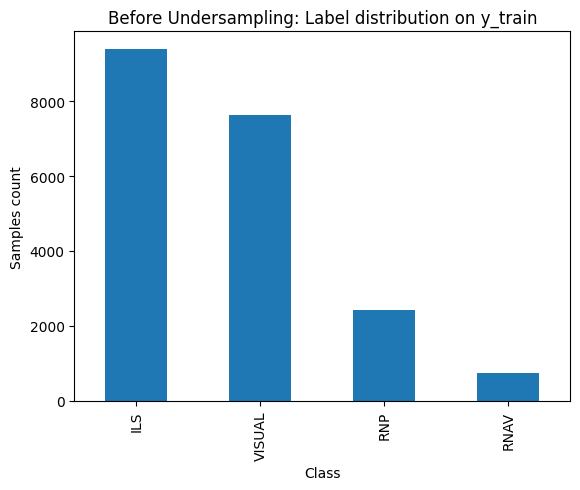

Label distribution:
 ILS       9390
VISUAL    7629
RNP       2442
RNAV       762
dtype: int64


In [7]:
# check for label distribution
label_counts = y_train.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('Before Undersampling: Label distribution on y_train')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [8]:
# Combine X and y for downsampling
train_combined = pd.concat([X_train, y_train], axis=1)

# Find min label count in training data
min_count = y_train.sum().min()

# Sample equal number of rows for each label
balanced_parts = []

for label in label_columns:
    subset = train_combined[train_combined[label] == 1]
    sampled = subset.sample(n=min_count, random_state=42)
    balanced_parts.append(sampled)

# Merge, shuffle, split back to X/y
balanced_train = pd.concat(balanced_parts).drop_duplicates()
balanced_train = shuffle(balanced_train, random_state=42)

X_train_bal = balanced_train[X.columns]
y_train_bal = balanced_train[label_columns]

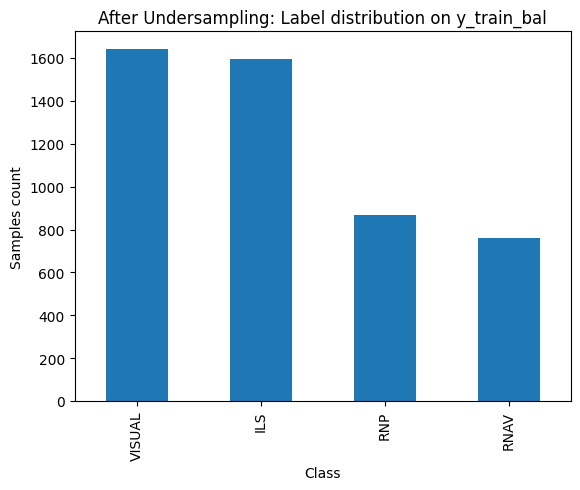

Label distribution:
 VISUAL    1642
ILS       1595
RNP        870
RNAV       762
dtype: int64


In [9]:
# check for label distribution after undersampling
label_counts = y_train_bal.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('After Undersampling: Label distribution on y_train_bal')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [10]:
# impute
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train_bal)
X_test = imputer.transform(X_test)

In [11]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# build and train multi-label model + hyperparameter tuning
def objective(trial):
    # Each hyperparameter is sampled by Optuna using Bayesian optimization
    C = trial.suggest_float('C', 0.01, 100)
    # kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 2, 4)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # if kernel == 'poly':
    #     degree = trial.suggest_int('degree', 2, 4)
    # else:
    #     degree = 3  # default poly degree

    # Create base model
    svc = SVC(
        C=C,
        kernel='poly',
        degree=degree,
        gamma=gamma,
        probability=True,
        class_weight='balanced',
        random_state=42
    )
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]

        model = OneVsRestClassifier(svc, n_jobs=1)
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, y_pred, average='macro')
        f1_scores.append(f1)
    
    return sum(f1_scores) / len(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=4)

[I 2025-06-16 16:29:06,505] A new study created in memory with name: no-name-dd100b0b-225a-4ea6-a5bd-26cacd65c005
[I 2025-06-16 16:29:22,723] Trial 0 finished with value: 0.9005524160740274 and parameters: {'C': 3.4195512425359498, 'degree': 3, 'gamma': 'scale'}. Best is trial 0 with value: 0.9005524160740274.
[I 2025-06-16 16:29:23,436] Trial 1 finished with value: 0.8973917403218457 and parameters: {'C': 72.78962698493292, 'degree': 3, 'gamma': 'scale'}. Best is trial 0 with value: 0.9005524160740274.
[I 2025-06-16 16:29:24,967] Trial 3 finished with value: 0.9027126038606207 and parameters: {'C': 16.495041907976745, 'degree': 4, 'gamma': 'auto'}. Best is trial 3 with value: 0.9027126038606207.
[I 2025-06-16 16:29:25,973] Trial 2 finished with value: 0.8947946347720961 and parameters: {'C': 53.22909244512728, 'degree': 2, 'gamma': 'scale'}. Best is trial 3 with value: 0.9027126038606207.
[I 2025-06-16 16:29:39,819] Trial 5 finished with value: 0.89799456466287 and parameters: {'C': 3

[I 2025-05-29 04:19:11,920] Trial 0 finished with value: 0.8957704548951723 and parameters: {'C': 63.09735330679972, 'kernel': 'poly', 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 04:19:16,298] Trial 1 finished with value: 0.8941025518113485 and parameters: {'C': 67.53577028993348, 'kernel': 'poly', 'gamma': 'scale', 'degree': 4}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 04:20:59,827] Trial 2 finished with value: 0.8834654316470868 and parameters: {'C': 14.185657980903137, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 05:07:16,146] Trial 3 finished with value: 0.8835263369060836 and parameters: {'C': 73.39938465406073, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 05:07:22,555] Trial 4 finished with value: 0.8939909657369384 and parameters: {'C': 29.958367323215715, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 05:07:27,736] Trial 5 finished with value: 0.889328365531412 and parameters: {'C': 95.3870706609792, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 05:07:32,152] Trial 6 finished with value: 0.8932890098355234 and parameters: {'C': 87.04875929472675, 'kernel': 'poly', 'gamma': 'scale', 'degree': 4}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 05:07:37,261] Trial 7 finished with value: 0.8937426384210624 and parameters: {'C': 44.07896264732635, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 05:07:42,654] Trial 8 finished with value: 0.8905844344754668 and parameters: {'C': 83.03384037504291, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 05:07:47,835] Trial 9 finished with value: 0.8905256330084326 and parameters: {'C': 1.032041383913268, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.8957704548951723.


[I 2025-05-29 05:07:51,429] Trial 10 finished with value: 0.896077758296587 and parameters: {'C': 55.72383754177118, 'kernel': 'poly', 'gamma': 'auto', 'degree': 3}. Best is trial 10 with value: 0.896077758296587.


[I 2025-05-29 05:07:55,127] Trial 11 finished with value: 0.8959777963080363 and parameters: {'C': 52.003133958470734, 'kernel': 'poly', 'gamma': 'auto', 'degree': 3}. Best is trial 10 with value: 0.896077758296587.


[I 2025-05-29 05:07:58,650] Trial 12 finished with value: 0.8962643153863269 and parameters: {'C': 47.25253783281988, 'kernel': 'poly', 'gamma': 'auto', 'degree': 3}. Best is trial 12 with value: 0.8962643153863269.


[I 2025-05-29 05:08:02,211] Trial 13 finished with value: 0.8963509934438197 and parameters: {'C': 38.415636195389276, 'kernel': 'poly', 'gamma': 'auto', 'degree': 3}. Best is trial 13 with value: 0.8963509934438197.


[I 2025-05-29 05:08:05,844] Trial 14 finished with value: 0.8965650275199296 and parameters: {'C': 34.62998750602964, 'kernel': 'poly', 'gamma': 'auto', 'degree': 3}. Best is trial 14 with value: 0.8965650275199296.


[I 2025-05-29 05:19:11,757] Trial 15 finished with value: 0.8835263369060836 and parameters: {'C': 29.03757610082431, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 14 with value: 0.8965650275199296.


[I 2025-05-29 05:19:18,356] Trial 16 finished with value: 0.894111573091881 and parameters: {'C': 34.90032671149394, 'kernel': 'poly', 'gamma': 'auto', 'degree': 2}. Best is trial 14 with value: 0.8965650275199296.


[I 2025-05-29 05:19:22,058] Trial 17 finished with value: 0.8994013908616587 and parameters: {'C': 17.42333586925959, 'kernel': 'poly', 'gamma': 'auto', 'degree': 3}. Best is trial 17 with value: 0.8994013908616587.


[I 2025-05-29 05:21:52,639] Trial 18 finished with value: 0.8835263369060836 and parameters: {'C': 17.61314880237924, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 17 with value: 0.8994013908616587.


[I 2025-05-29 05:21:57,611] Trial 19 finished with value: 0.8972347187139528 and parameters: {'C': 16.83167657861715, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 17 with value: 0.8994013908616587.


In [13]:
print(f"Best params:, {study.best_trial.params}")
print(f"Best F1:, {study.best_value}")

Best params:, {'C': 16.495041907976745, 'degree': 4, 'gamma': 'auto'}
Best F1:, 0.9027126038606207


In [14]:
# save all trials log
df = study.trials_dataframe()
df.to_csv("../../optuna_trials/svm_ovr_with_airport_feats_optuna_trials.csv", index=False)

In [15]:
# save trained best model
best_params = study.best_trial.params
best_model = OneVsRestClassifier(SVC(
    **best_params,
    kernel='poly',
    probability=True,
    class_weight='balanced',
    random_state=42
))

best_model.fit(X_train_scaled, y_train_bal)

with open("../../trained_models/model-svm-ovr-BYS-poly-with_airport_feats.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [16]:
# features in order
feature_order = list(X.columns)

# save to json
with open("../../feature_order/feature_order_svm_ovr_BYS_poly_with_airport_feats.json", "w") as f:
    json.dump(feature_order, f)

In [17]:
# predict and evaluate
y_pred = best_model.predict(X_test_scaled)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 14 out of 3376
[[ 3.  3.  0. ...  0.  0.  1.]
 [10. 17. 25. ...  0.  1.  0.]
 [10. 17. 25. ...  1.  0.  0.]
 ...
 [10. 18. 28. ...  0.  1.  0.]
 [ 3.  4.  0. ...  0.  0.  1.]
 [ 4.  3.  0. ...  0.  0.  1.]]
              precision    recall  f1-score   support

         ILS       0.93      0.90      0.91      2363
        RNAV       0.31      0.87      0.45       186
         RNP       1.00      1.00      1.00       613
      VISUAL       0.74      0.89      0.81      1886

   micro avg       0.80      0.90      0.85      5048
   macro avg       0.74      0.91      0.79      5048
weighted avg       0.85      0.90      0.87      5048
 samples avg       0.81      0.89      0.83      5048



C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


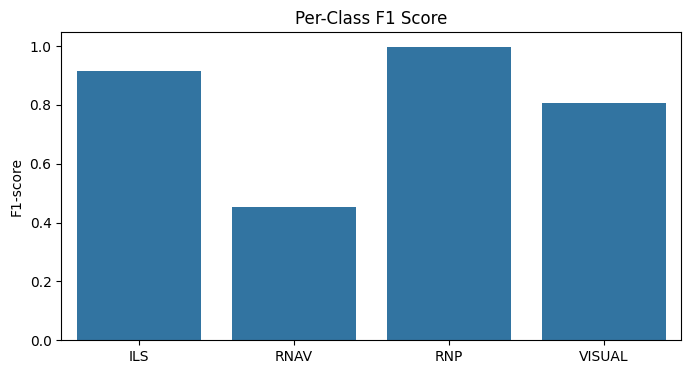

In [18]:
# per-class F1-score bar chart
report = classification_report(y_test, y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(len(label_columns))]
plt.figure(figsize=(8,4))
sns.barplot(x=label_columns, y=f1_scores)
plt.title("Per-Class F1 Score")
plt.ylabel("F1-score")
plt.show()

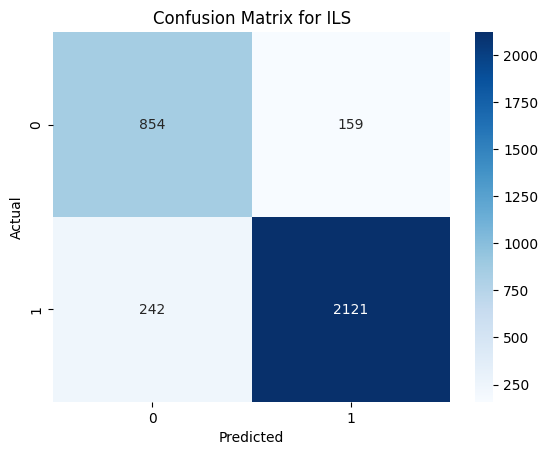

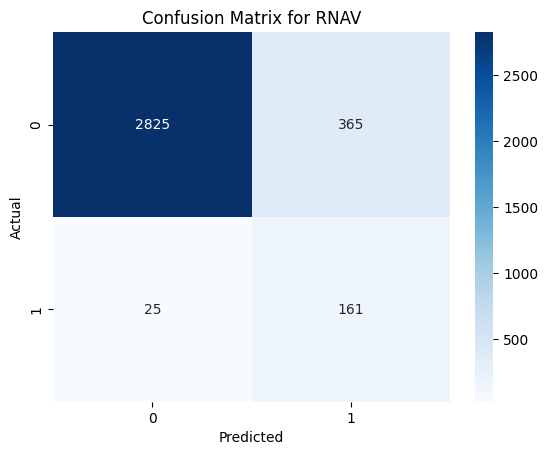

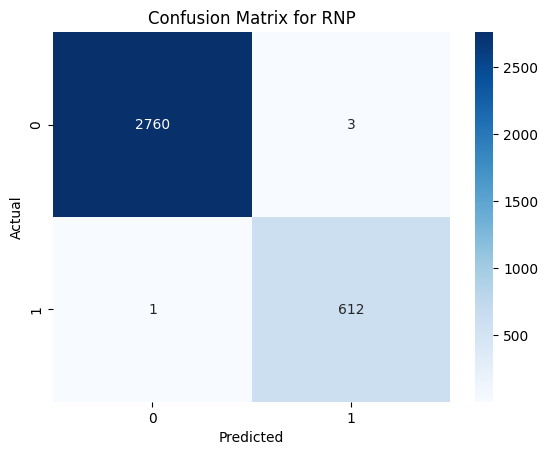

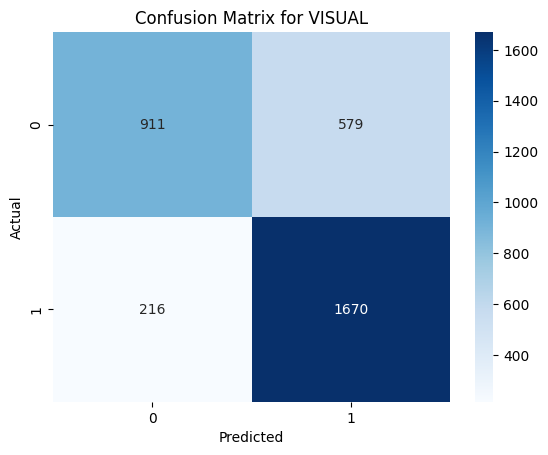

In [19]:
# confusion matrix per label
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(label_columns):
    plt.figure()
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"../../visualizations/confusion-matrix/with_airport_features-OVR/{label}-with_airport_features-ovr-BYS-poly.png")
    plt.show()

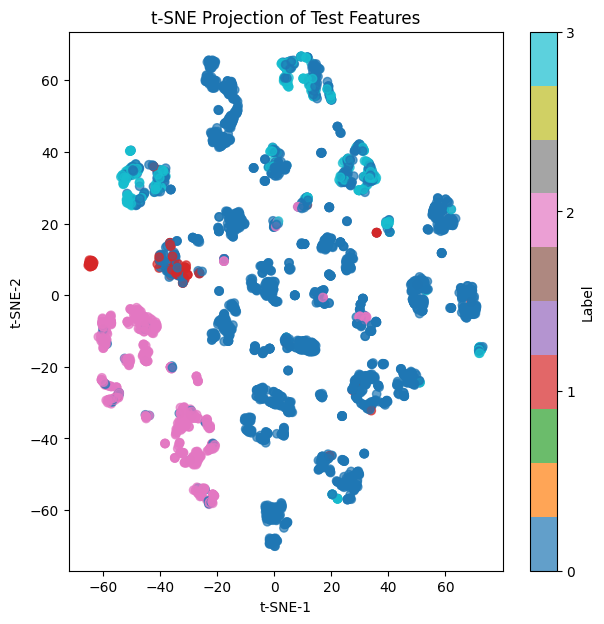

In [20]:
# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_proj = tsne.fit_transform(X_test_scaled)
dominant_label = np.argmax(y_test.values, axis=1)
plt.figure(figsize=(7,7))
plt.scatter(X_proj[:,0], X_proj[:,1], c=dominant_label, cmap='tab10', alpha=0.7)
plt.title('t-SNE Projection of Test Features')
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.colorbar(ticks=range(len(label_columns)), label='Label')
plt.savefig("../../visualizations/t-SNE/with_airport_features-ovr-BYS-poly.png")
plt.show()

SHAP summary plot for ILS


  0%|          | 0/50 [00:00<?, ?it/s]

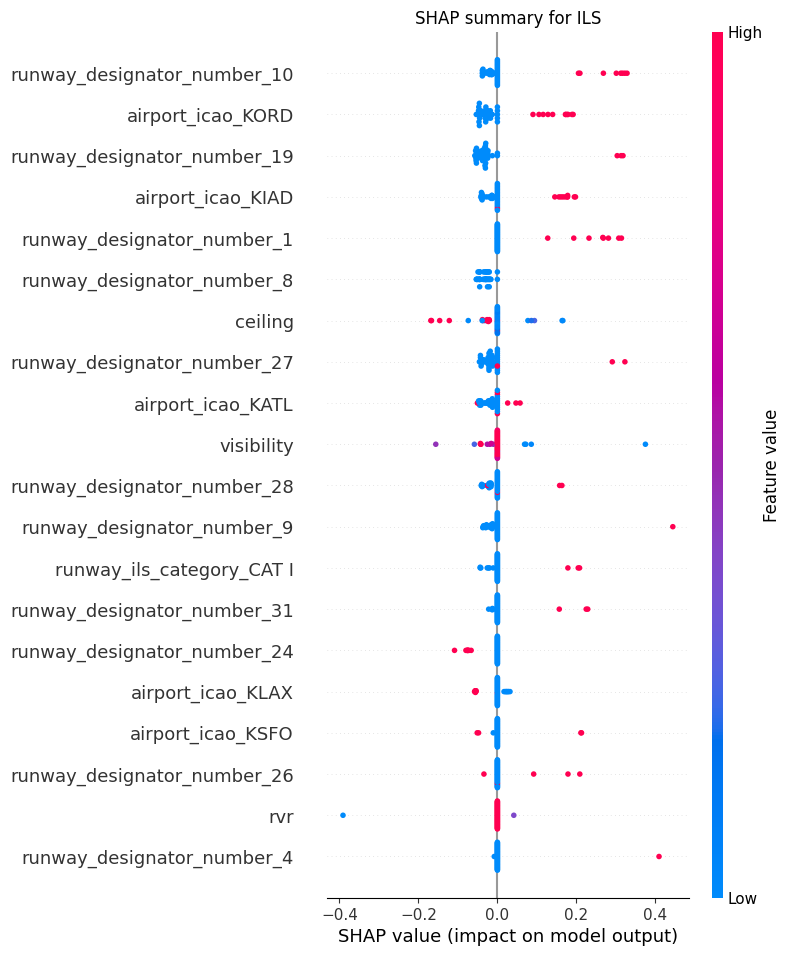

SHAP summary plot for RNAV


  0%|          | 0/50 [00:00<?, ?it/s]

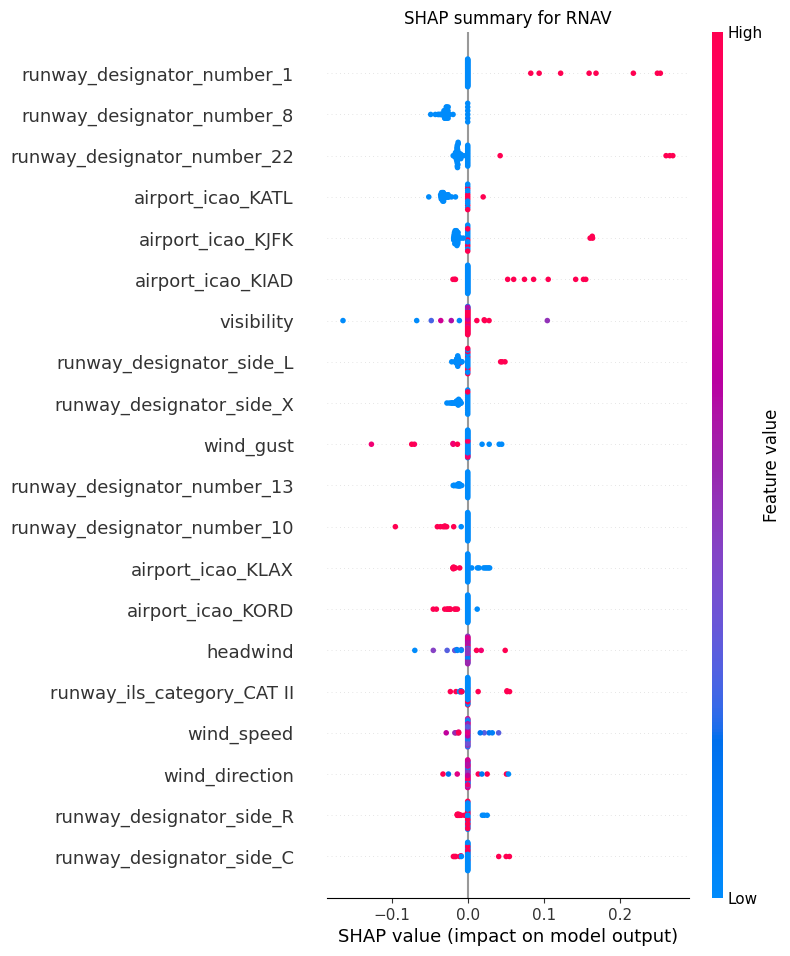

SHAP summary plot for RNP


  0%|          | 0/50 [00:00<?, ?it/s]

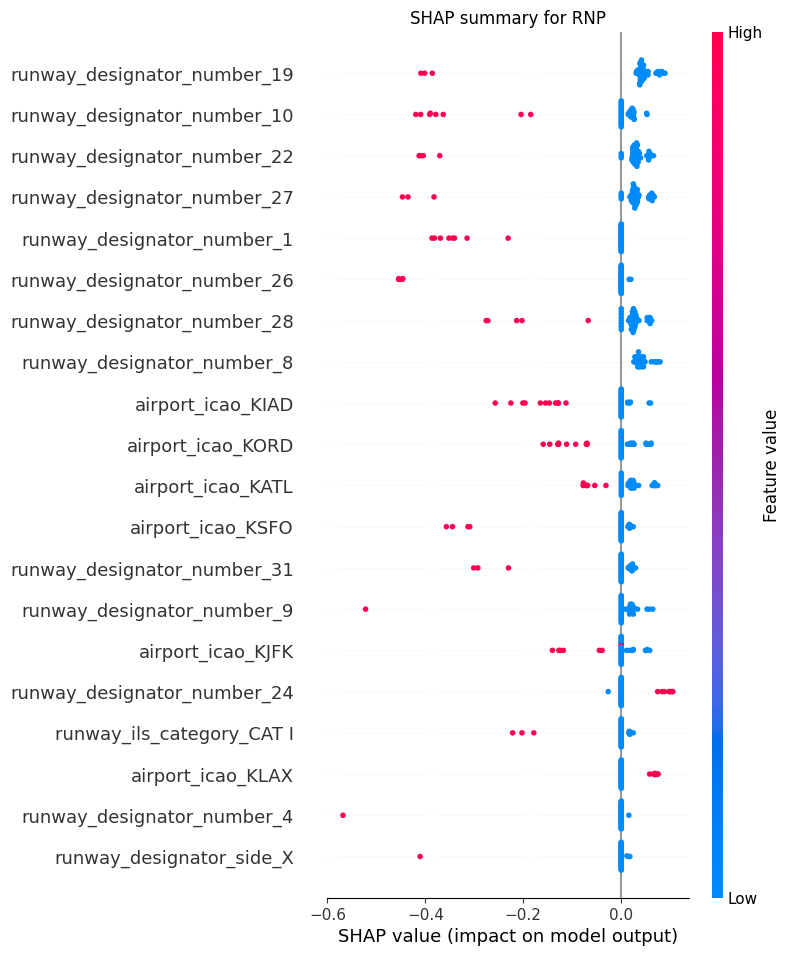

SHAP summary plot for VISUAL


  0%|          | 0/50 [00:00<?, ?it/s]

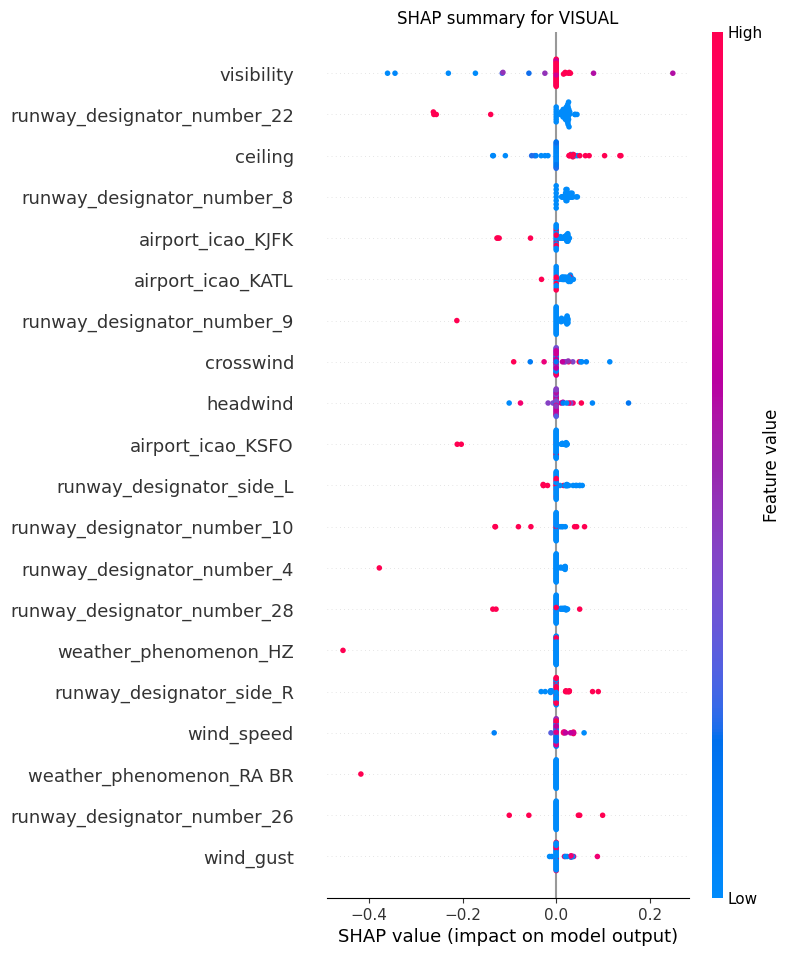

In [21]:
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

for idx, label in enumerate(label_columns):
    print(f"SHAP summary plot for {label}")
    
    clf = best_model.estimators_[idx]
    background = shap.sample(X_train_df, 50, random_state=42)
    X_sample = shap.sample(X_test_df, 50, random_state=42)

    # Fix: only use probability of positive class
    explainer = shap.KernelExplainer(lambda X: clf.predict_proba(X)[:, 1], background)
    shap_values = explainer.shap_values(X_sample)

    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f"SHAP summary for {label}")
    plt.savefig(f"../../visualizations/SHAP/with_airport_features-OVR/{label}-with_airport_features-ovr-BYS-poly.png")
    plt.show()

In [22]:
# Buat versi DataFrame dari scaled test set (agar bisa dibaca dan di-display)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Evaluasi false predictions
for i, label in enumerate(label_columns):
    print(f"\n====== {label} ======")

    # Ambil indeks FP dan FN
    false_positives = np.where((y_test[label].values == 0) & (y_pred[:, i] == 1))[0]
    false_negatives = np.where((y_test[label].values == 1) & (y_pred[:, i] == 0))[0]

    # Ambil data FP
    print(f"\n{label} False Positives (max 5):")
    fp_idx = false_positives[:5]
    df_fp = X_test_df.iloc[fp_idx].copy()
    df_fp['y_true'] = y_test.iloc[fp_idx][label].values
    df_fp['y_pred'] = y_pred[fp_idx, i]
    display(df_fp)

    # Ambil data FN
    print(f"{label} False Negatives (max 5):")
    fn_idx = false_negatives[:5]
    df_fn = X_test_df.iloc[fn_idx].copy()
    df_fn['y_true'] = y_test.iloc[fn_idx][label].values
    df_fn['y_pred'] = y_pred[fn_idx, i]
    display(df_fn)



====== ILS ======

ILS False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III,y_true,y_pred
13,0.371649,1.267853,2.454190,-0.372621,0.089348,-0.109675,2.562694,-0.810423,2.789827,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1
17,0.371649,-0.446129,-0.506362,0.852148,0.089348,0.115172,0.307791,-0.600105,2.789827,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,2.384968,-1.791031,0,1
23,-2.260034,-1.779226,-0.506362,-1.903583,0.089348,-0.993003,0.111712,-0.915581,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1
55,0.371649,-1.207899,-0.506362,1.158340,0.089348,-1.362395,-0.198746,-0.343051,2.789827,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1
64,0.371649,-0.827014,-0.506362,0.137699,0.089348,-1.394516,0.814327,1.409571,2.789827,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1


ILS False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III,y_true,y_pred
21,0.371649,0.886968,1.499173,1.464532,0.089348,-0.222099,2.268577,1.409571,2.789827,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,2.384968,-1.791031,1,0
30,0.371649,-0.065244,-0.506362,0.750084,0.089348,0.372140,-0.394824,1.409571,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,1,0
91,-0.154688,-1.017456,-0.506362,-1.393262,0.089348,-1.619363,0.226091,-0.896886,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,1,0
98,0.371649,-1.207899,-0.506362,0.545955,0.089348,-0.623612,-0.198746,1.409571,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,2.384968,-1.791031,1,0
127,0.371649,2.029623,2.358688,0.137699,0.089348,2.026373,-0.999400,-0.343051,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,1,0



====== RNAV ======

RNAV False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III,y_true,y_pred
17,0.371649,-0.446129,-0.506362,0.852148,0.089348,0.115172,0.307791,-0.600105,2.789827,-0.481060,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,2.384968,-1.791031,0,1
48,0.371649,-1.207899,-0.506362,-1.291198,0.089348,-0.687854,0.487529,-0.752001,-0.358445,2.078742,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,2.384968,-1.791031,0,1
51,0.371649,-1.017456,-0.506362,1.464532,0.089348,-0.495127,-0.313125,1.409571,-0.358445,2.078742,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,2.384968,-1.791031,0,1
54,0.371649,-1.207899,-0.506362,-1.087070,0.089348,-0.832398,0.569229,-0.343051,-0.358445,2.078742,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1
55,0.371649,-1.207899,-0.506362,1.158340,0.089348,-1.362395,-0.198746,-0.343051,2.789827,-0.481060,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1


RNAV False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III,y_true,y_pred
111,-0.154688,-1.017456,-0.506362,0.750084,0.089348,-0.366643,-0.002667,-0.343051,-0.358445,-0.481060,...,-0.239349,-0.069457,-8.079154,-0.032092,10.344080,-0.310890,-0.419293,0.558338,1,0
170,-0.154688,0.315641,1.308170,-0.168493,0.089348,-0.993003,-1.685675,-0.887539,2.789827,-0.481060,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.310890,2.384968,-1.791031,1,0
213,0.371649,1.458295,1.976682,1.566596,0.089348,1.367892,1.500602,-0.343051,-0.358445,-0.481060,...,4.178001,-0.069457,0.123775,-0.032092,-0.096674,3.216567,-0.419293,-1.791031,1,0
352,0.371649,-1.779226,-0.506362,-1.903583,0.089348,-0.993003,0.111712,-0.831454,-0.358445,2.078742,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.310890,-0.419293,0.558338,1,0
566,0.371649,-1.779226,-0.506362,-1.903583,0.089348,-0.993003,0.111712,-0.343051,-0.358445,-0.481060,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,3.216567,-0.419293,-1.791031,1,0



====== RNP ======

RNP False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III,y_true,y_pred
1691,-3.839044,-0.255687,-0.506362,0.852148,-11.122994,-0.768156,1.402563,-0.887539,-0.358445,2.078742,...,-0.239349,-0.069457,-8.079154,31.160873,-0.096674,-0.310890,-0.419293,0.558338,0,1
2895,-2.260034,-0.446129,-0.506362,0.341827,-7.287192,-0.013312,0.683608,-0.915581,-0.358445,2.078742,...,-0.239349,-0.069457,-8.079154,-0.032092,10.344080,-0.310890,-0.419293,0.558338,0,1
3345,0.371649,-0.065244,-0.506362,-0.372621,0.089348,0.259717,0.847007,1.409571,-0.358445,2.078742,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,3.216567,-0.419293,-1.791031,0,1


RNP False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III,y_true,y_pred
116,0.371649,0.315641,1.976682,0.648019,0.089348,0.661229,-0.509204,-0.89455,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,1,0



====== VISUAL ======

VISUAL False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III,y_true,y_pred
1,0.371649,-0.827014,-0.506362,0.852148,0.089348,-0.189978,0.111712,1.409571,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1
9,0.371649,2.220065,3.313705,1.056276,0.089348,1.930010,1.827400,-0.854823,2.789827,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,2.384968,-1.791031,0,1
11,0.371649,0.886968,1.690177,0.750084,0.089348,1.223347,-0.280445,1.409571,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1
16,0.371649,-0.446129,-0.506362,-0.985006,0.089348,0.131232,0.111712,-0.343051,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1
18,0.371649,0.696526,-0.506362,-1.495326,0.089348,0.050930,-1.734695,1.409571,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,0,1


VISUAL False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III,y_true,y_pred
17,0.371649,-0.446129,-0.506362,0.852148,0.089348,0.115172,0.307791,-0.600105,2.789827,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,2.384968,-1.791031,1,0
26,0.371649,-0.827014,-0.506362,1.668660,0.089348,-1.137548,-0.688942,-0.529999,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,1,0
33,0.371649,-1.017456,-0.506362,-1.597390,0.089348,-0.671793,-0.460184,-0.226208,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,1,0
55,0.371649,-1.207899,-0.506362,1.158340,0.089348,-1.362395,-0.198746,-0.343051,2.789827,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,1,0
62,0.371649,-0.827014,-0.506362,-1.801519,0.089348,-0.993003,-0.705282,1.409571,-0.358445,-0.48106,...,-0.239349,-0.069457,0.123775,-0.032092,-0.096674,-0.31089,-0.419293,0.558338,1,0
